In [1]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer, SimpleImputer
from sklearn.compose import ColumnTransformer

import duckdb

import plotly.express as px
import plotly.graph_objects as go

import re
from scipy.stats import pearsonr

In [2]:
#https://www.iban.com/country-codes

#^^^where I got the country codes may need to get rid of the parenthesis
data = pd.read_csv('country_map.txt', delimiter='\t')
country_map = dict(zip(data['Country'], data['Code']))

Index(['Country', '2', 'Code', 'num'], dtype='object')
{'Afghanistan': 'AFG', 'Albania': 'ALB', 'Algeria': 'DZA', 'American Samoa': 'ASM', 'Andorra': 'AND', 'Angola': 'AGO', 'Anguilla': 'AIA', 'Antarctica': 'ATA', 'Antigua and Barbuda': 'ATG', 'Argentina': 'ARG', 'Armenia': 'ARM', 'Aruba': 'ABW', 'Australia': 'AUS', 'Austria': 'AUT', 'Azerbaijan': 'AZE', 'Bahamas (the)': 'BHS', 'Bahamas': 'BHS', 'Bahrain': 'BHR', 'Bangladesh': 'BGD', 'Barbados': 'BRB', 'Belarus': 'BLR', 'Belgium': 'BEL', 'Belize': 'BLZ', 'Benin': 'BEN', 'Bermuda': 'BMU', 'Bhutan': 'BTN', 'Bolivia (Plurinational State of)': 'BOL', 'Bolivia': 'BOL', 'Bonaire, Sint Eustatius and Saba': 'BES', 'Bosnia and Herzegovina': 'BIH', 'Botswana': 'BWA', 'Bouvet Island': 'BVT', 'Brazil': 'BRA', 'British Indian Ocean Territory': 'IOT', 'Brunei Darussalam': 'BRN', 'Bulgaria': 'BGR', 'Burkina Faso': 'BFA', 'Burundi': 'BDI', 'Cabo Verde': 'CPV', 'Cambodia': 'KHM', 'Cameroon': 'CMR', 'Canada': 'CAN', 'Cayman Islands': 'CYM', 'Central Afr

# Education

In [3]:
schooling_years_df = pd.read_csv("schooling_years.csv", delimiter=";")
schooling_years_df.drop(columns='Entity', inplace=True)
schooling_years_df.rename(columns={'avg_years_of_schooling': 'Average Years of Schooling'}, inplace=True)
education_df = schooling_years_df
education_df.head()

Code  Year  Average Years of Schooling
0  AFG  1870                        0.01
1  AFG  1875                        0.01
2  AFG  1880                        0.01
3  AFG  1885                        0.01
4  AFG  1890                        0.01

# internet access

In [4]:
internet_df = pd.read_csv('internet_access_by_country 1989-2022.csv', 
                          thousands=",")
########################################################################
internet_df = internet_df.drop(['Unnamed: 67', 'Indicator Name', 'Indicator Code'], 
                               axis=1)

years_int = []
for year in range(1960, 2023):
    years_int.append(year)
years_str = [str(year) for year in years_int]

internet_df_melt = pd.melt(internet_df, 
                           id_vars=['Country Name','Country Code'], 
                           value_vars=years_str, 
                           var_name = 'year', 
                           value_name = 'internet access')
internet_df_melt.drop(columns='Country Name', inplace=True)
internet_df_melt = internet_df_melt.rename(columns={'year': 'Year'})
internet_df = internet_df_melt
internet_df.head()

Country Code  Year  internet access
0          ABW  1960              NaN
1          AFE  1960              NaN
2          AFG  1960              NaN
3          AFW  1960              NaN
4          AGO  1960              NaN

# religion

In [5]:
religions_df = pd.read_csv('religions_by_country_1945-2010.csv', thousands=",")
########################################################################
religions = []

for i in range(len(religions_df.columns)):
    column_name = religions_df.columns[i]
    
    if column_name in ['year', 'state', 'code']:
        continue
    if (religions_df[column_name].dtype == float):
        religions_df[column_name]=pd.to_numeric(religions_df[column_name], 
                                downcast='integer')
    religions.append(religions_df[column_name])
    
    if column_name == 'religion_all':
        break
        
i = 0
eachrow = 0
topreligion = []
max_index = 0

#goes through all of the rows
for eachrow in range(religions_df.shape[0]): 
    valuelist = []
    
    #checks each religion
    for i in range(len(religions)): 
        #indexes the value of the religion in question
        value = religions_df.iloc[eachrow, 3+i] 
        valuelist.append(value)
        if ("all" in religions_df.columns[3+i]):
            valuelist[-1] = 0
    max_index = valuelist.index(max(valuelist))
    topreligion.append(religions_df.columns[3+ max_index])
    
top_df = religions_df[['year', 'code']].copy()
top_df['topReligion'] = topreligion
top_df = top_df.rename(columns={'year': 'Year'})
religion_df = top_df
religion_df.head()


Year code              topReligion
0  1945  USA  christianity_protestant
1  1950  USA  christianity_protestant
2  1955  USA  christianity_protestant
3  1960  USA  christianity_protestant
4  1965  USA  christianity_protestant

# Political Spectrum

In [6]:
wiki_democracy_url = "https://en.m.wikipedia.org/wiki/The_Economist_Democracy_Index"

wiki_democracy_result = requests.get(wiki_democracy_url)

if wiki_democracy_result.status_code != 200:
    print("something went wrong:", wiki_democracy_result)
    
wiki_democracy_text = wiki_democracy_result.text

wiki_democracy_html = BeautifulSoup(wiki_democracy_text, "html.parser")

country_democracy_list = wiki_democracy_html.find_all('table',
attrs={'class':"wikitable sortable",
        'style':"text-align:center;"})
country_democracy_df = pd.read_html(str(country_democracy_list))[1]
########################################################################
country_democracy_df = country_democracy_df.rename(
        columns = {"Regime type":"Regime_Type",
        "2022 rank":"2022_Rank"})
########################################################################
country_democracy_df = country_democracy_df.melt(
    id_vars = ["Region","2022_Rank","Country","Regime_Type"],
    value_vars = ["2022","2021","2020","2019","2018","2017",
                  "2016","2015","2014","2013","2012","2011","2010"], 
    var_name = "Year", 
    value_name = "Democracy_Index")
########################################################################
scrubbed_democracy_df = country_democracy_df.drop(
                ['Region', '2022_Rank'], 
                  axis=1)
scrubbed_democracy_df.drop(columns='Regime_Type', inplace=True)
political_df = scrubbed_democracy_df
political_df.head()
########################################################################


C:\Users\Owner\AppData\Local\Temp\ipykernel_14020\3909952454.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  country_democracy_df = pd.read_html(str(country_democracy_list))[1]


Country  Year  Democracy_Index
0         Canada  2022             8.88
1  United States  2022             7.85
2        Austria  2022             8.20
3        Belgium  2022             7.64
4         Cyprus  2022             7.38

# Wealth

In [7]:
wiki_wealth_url = "https://en.wikipedia.org/wiki/List_of_countries_by_total_wealth"

wiki_wealth_result = requests.get(wiki_wealth_url)

if wiki_wealth_result.status_code != 200:
    print("something went wrong:", wiki_wealth_result)
    
wiki_wealth_text = wiki_wealth_result.text

wiki_wealth_html = BeautifulSoup(wiki_wealth_text, "html.parser")

country_wealth_list = wiki_wealth_html.find_all('table',
attrs={'class':"wikitable sortable"})

country_wealth_df_0to9 = pd.read_html(str(country_wealth_list))[0]

country_wealth_df_0to9.head()
########################################################################
country_wealth_df_10to19 = pd.read_html(str(country_wealth_list))[1]

country_wealth_df_10to19.head()
########################################################################
country_wealth_df_20to22 = pd.read_html(str(country_wealth_list))[2]

country_wealth_df_20to22.head()
########################################################################
combined1 = pd.concat([country_wealth_df_0to9, country_wealth_df_10to19], 
                      ignore_index=True)
combined = pd.concat([combined1,country_wealth_df_20to22],
                     ignore_index=True)
########################################################################
new_df = combined.melt(id_vars = ["Year"],
value_vars = ["Australia","Canada","China","France","Germany","India","Italy",
            "Japan","South Korea","Spain","United Kingdom","United States"],
var_name = "Countries", value_name = "Wealth_share_percent")

new_df["Wealth_share_percent"]=new_df["Wealth_share_percent"].str.rstrip("%")
new_df = new_df.replace("—", np.nan, regex=True)
new_df["Wealth_share_percent"] = new_df["Wealth_share_percent"].astype(float)
wealth_df = new_df
wealth_df.head()
########################################################################


C:\Users\Owner\AppData\Local\Temp\ipykernel_14020\2992837304.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  country_wealth_df_0to9 = pd.read_html(str(country_wealth_list))[0]
C:\Users\Owner\AppData\Local\Temp\ipykernel_14020\2992837304.py:19: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  country_wealth_df_10to19 = pd.read_html(str(country_wealth_list))[1]
C:\Users\Owner\AppData\Local\Temp\ipykernel_14020\2992837304.py:23: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  country_wealth_df_20to22 = pd.read_html(str(country_wealth_list))[2]


Year  Countries  Wealth_share_percent
0  2000  Australia                   NaN
1  2001  Australia                   NaN
2  2002  Australia                   NaN
3  2003  Australia                   1.9
4  2004  Australia                   1.9

# also the NaNs are ........

# Alien stuff

In [8]:
np.random.seed(2950)

df = pd.DataFrame(columns=["Occurred", "Location"])
base_url = "https://nuforc.org/sighting/?id="

session = requests.Session()  # Create a persistent session outside the loop

numbers = list(range(1, 1000001))
np.random.shuffle(numbers)

counter = 1
for number in range(89,200):
    empty_series = pd.Series({
        "Occurred": "",
        "Location": ""
    })

    url = base_url + str(numbers[number])
    response = session.get(url)
    print(counter)
    counter += 1
    
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        soup = soup.find(id="primary")
        occurredtext = str(soup.b.next_sibling.string)
        if occurredtext == 'Local':
            continue
        locationtext = str(soup.b.next_sibling.next_sibling.next_sibling.next_sibling.string)

        empty_series["Occurred"] = empty_series["Occurred"] + occurredtext
        empty_series["Location"] = empty_series["Location"] + locationtext
        
        df = pd.concat([df, empty_series.to_frame().T])

alien_df = df[df['Occurred'] != '  Local']
alien_df.head()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111


Occurred                                 Location
0   2005-02-22 15:45:00 Local               Netherlands, , Netherlands
0   2020-05-30 23:15:00 Local   Amelia (suburb of Cincinnati), OH, USA
0   2020-03-05 20:17:00 Local                      Harrisburg, PA, USA
0   2020-10-03 20:30:00 Local                        Ballston, NY, USA
0   2017-05-10 05:35:00 Local                           Tampa, FL, USA

In [9]:
alien_df_copy = alien_df.copy()

def loc_fix(string, key):
    last_index = string.rfind(key)
    if last_index != -1:
        rest_of_string = string[last_index + len(key):]
        return rest_of_string.strip()
    else:
        return None

for number in range(0,(alien_df_copy.shape[0])):
    occur = alien_df_copy.iloc[number, 0]
    occur = occur[:occur.find("-")].strip()
    alien_df_copy.iloc[number, 0] = occur
    # print(occur)
    location = alien_df_copy.iloc[number, 1]
    location = loc_fix(location, ",")
    alien_df_copy.iloc[number, 1] = location
    # print(location)
alien_df = alien_df_copy
# alien_df.head()

In [10]:
#https://www.iban.com/country-codes
alien_df_copy = alien_df.copy()
# print(alien_df.iloc[:,1].unique())

alien_df_copy['Location'] = alien_df_copy['Location'].map(country_map).fillna(alien_df_copy['Location'])
alien_df = alien_df_copy
# print(alien_df_copy)

    

In [11]:
pivot_df = alien_df.pivot_table(index="Location", columns="Occurred", aggfunc='size', fill_value=0)
pivot_df.columns = pivot_df.columns.astype(str)

melted_df = pivot_df.reset_index().melt(id_vars='Location', var_name='Year', value_name='Value')
melted_df = melted_df.rename(columns={'Location': 'Country Code', 'Value': 'Sightings'})
alien_df = melted_df
print(melted_df.head(10))
print(melted_df.iloc[:,2].unique())

  Country Code  Year  Sightings
0          BRA  1963          0
1          NLD  1963          0
2          USA  1963          1
3          BRA  1995          0
4          NLD  1995          0
5          USA  1995          1
6          BRA  1999          0
7          NLD  1999          0
8          USA  1999          1
9          BRA  2000          0
[0 1 4 3]


# COMBINING TIME!!!!!

In [12]:
dfs = [education_df, internet_df, political_df, religion_df, wealth_df, alien_df]

print(education_df.head(1))
print("----------------------------------")
print(internet_df.head(1))
print("----------------------------------")
print(political_df.head(1))
print("----------------------------------")
print(religion_df.head(1))
print("----------------------------------")
print(wealth_df.head(1))
print("----------------------------------")
print(alien_df.head(1))

  Code  Year  Average Years of Schooling
0  AFG  1870                        0.01
----------------------------------
  Country Code  Year  internet access
0          ABW  1960              NaN
----------------------------------
  Country  Year  Democracy_Index
0  Canada  2022             8.88
----------------------------------
   Year code              topReligion
0  1945  USA  christianity_protestant
----------------------------------
   Year  Countries  Wealth_share_percent
0  2000  Australia                   NaN
----------------------------------
  Country Code  Year  Sightings
0          BRA  1963          0


In [13]:
####type casting time
for df in dfs:
    df.columns = [np.str_(col) for col in df.columns]
for df in dfs:
    if 'Year' in df.columns:
        df['Year'] = df['Year'].astype(int)

In [14]:
#adding educaiton
merged_df = pd.merge(alien_df, education_df, left_on=['Country Code', 'Year'], right_on=['Code', 'Year'], how='left')
merged_df.drop(columns='Code', inplace=True)

print(merged_df.head())

  Country Code  Year  Sightings  Average Years of Schooling
0          BRA  1963          0                         NaN
1          NLD  1963          0                         NaN
2          USA  1963          1                         NaN
3          BRA  1995          0                         4.6
4          NLD  1995          0                        10.5


In [15]:
#adding internet
merged_df = pd.merge(merged_df, internet_df, on=['Country Code', 'Year'], how='left')

print(merged_df.head())

  Country Code  Year  Sightings  Average Years of Schooling  internet access
0          BRA  1963          0                         NaN              NaN
1          NLD  1963          0                         NaN              NaN
2          USA  1963          1                         NaN              NaN
3          BRA  1995          0                         4.6         0.105138
4          NLD  1995          0                        10.5         6.473158


In [16]:
#adding religion as making it dummies since its categorical
merged_df = pd.merge(merged_df, religion_df, left_on=['Country Code', 'Year'], right_on=['code', 'Year'], how='left')

religion_dummies = pd.get_dummies(merged_df['topReligion'])
religion_dummies = religion_dummies.astype(int)
merged_df = pd.concat([merged_df, religion_dummies], axis=1)
merged_df.drop('topReligion', axis=1, inplace=True)
merged_df.drop(columns='code', inplace=True)

print(merged_df.head())

  Country Code  Year  Sightings  Average Years of Schooling  internet access  \
0          BRA  1963          0                         NaN              NaN   
1          NLD  1963          0                         NaN              NaN   
2          USA  1963          1                         NaN              NaN   
3          BRA  1995          0                         4.6         0.105138   
4          NLD  1995          0                        10.5         6.473158   

   christianity_protestant  christianity_romancatholic  
0                        0                           0  
1                        0                           0  
2                        0                           0  
3                        0                           1  
4                        0                           0  


In [17]:
#fixing up the country code stuff for political and wealth df

political_df['Country'] = political_df['Country'].map(country_map).fillna(political_df['Country'])
wealth_df['Countries'] = wealth_df['Countries'].map(country_map).fillna(wealth_df['Countries'])

print(wealth_df.head(1))
print(political_df.head(1))

   Year Countries  Wealth_share_percent
0  2000       AUS                   NaN
  Country  Year  Democracy_Index
0     CAN  2022             8.88


In [18]:
merged_df = pd.merge(merged_df, political_df, left_on=['Country Code', 'Year'], right_on=['Country', 'Year'], how='left')
merged_df.drop(columns='Country', inplace=True)

print(merged_df.head())

  Country Code  Year  Sightings  Average Years of Schooling  internet access  \
0          BRA  1963          0                         NaN              NaN   
1          NLD  1963          0                         NaN              NaN   
2          USA  1963          1                         NaN              NaN   
3          BRA  1995          0                         4.6         0.105138   
4          NLD  1995          0                        10.5         6.473158   

   christianity_protestant  christianity_romancatholic  Democracy_Index  
0                        0                           0              NaN  
1                        0                           0              NaN  
2                        0                           0              NaN  
3                        0                           1              NaN  
4                        0                           0              NaN  


In [19]:
merged_df = pd.merge(merged_df, wealth_df, left_on=['Country Code', 'Year'], right_on=['Countries', 'Year'], how='left')
merged_df.drop(columns='Countries', inplace=True)

print(merged_df.head())

  Country Code  Year  Sightings  Average Years of Schooling  internet access  \
0          BRA  1963          0                         NaN              NaN   
1          NLD  1963          0                         NaN              NaN   
2          USA  1963          1                         NaN              NaN   
3          BRA  1995          0                         4.6         0.105138   
4          NLD  1995          0                        10.5         6.473158   

   christianity_protestant  christianity_romancatholic  Democracy_Index  \
0                        0                           0              NaN   
1                        0                           0              NaN   
2                        0                           0              NaN   
3                        0                           1              NaN   
4                        0                           0              NaN   

   Wealth_share_percent  
0                   NaN  
1               

In [20]:
everything_df = merged_df.copy()
everything_df.head()

Country Code  Year  Sightings  Average Years of Schooling  internet access  \
0          BRA  1963          0                         NaN              NaN   
1          NLD  1963          0                         NaN              NaN   
2          USA  1963          1                         NaN              NaN   
3          BRA  1995          0                         4.6         0.105138   
4          NLD  1995          0                        10.5         6.473158   

   christianity_protestant  christianity_romancatholic  Democracy_Index  \
0                        0                           0              NaN   
1                        0                           0              NaN   
2                        0                           0              NaN   
3                        0                           1              NaN   
4                        0                           0              NaN   

   Wealth_share_percent  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN

In [21]:
print(everything_df.iloc[:,0].unique())
everything_df.columns = [np.str_(col) for col in everything_df.columns]

for col in everything_df.columns:
    print(type(col))

['BRA' 'NLD' 'USA']
<class 'numpy.str_'>
<class 'numpy.str_'>
<class 'numpy.str_'>
<class 'numpy.str_'>
<class 'numpy.str_'>
<class 'numpy.str_'>
<class 'numpy.str_'>
<class 'numpy.str_'>
<class 'numpy.str_'>


In [22]:
imputer = SimpleImputer(strategy='mean')
columns_to_impute = ['Year', 'Average Years of Schooling', 'internet access', 
                     'christianity_protestant', 'christianity_romancatholic', 
                     'Democracy_Index', 'Wealth_share_percent']
everything_df[columns_to_impute] = imputer.fit_transform(everything_df[columns_to_impute])

In [29]:
X = everything_df[['Year', 'Average Years of Schooling',
       'internet access', 'christianity_protestant',
       'christianity_romancatholic', 'Democracy_Index',
       'Wealth_share_percent']]
y = everything_df['Sightings']
model = LinearRegression()


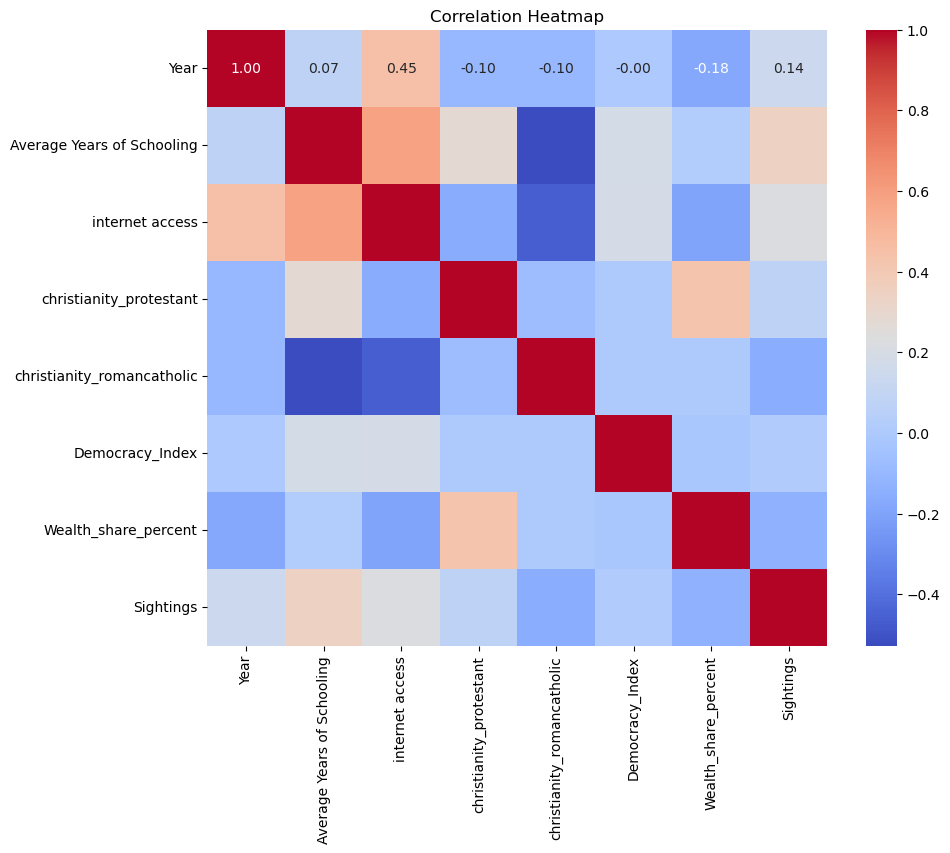

In [30]:
plot_data = X.copy()
plot_data['Sightings'] = y

correlation_matrix = plot_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Root Mean Squared Error (RMSE): 0.52


In [ ]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.title(f'Actual vs Predicted\nRMSE: {rmse:.2f}')
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)), color='red')

plt.show()

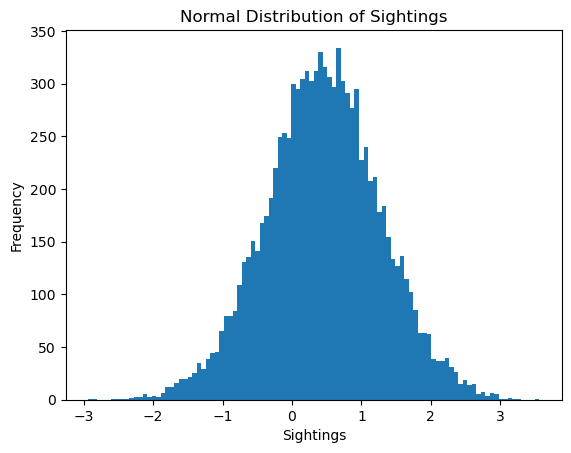

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


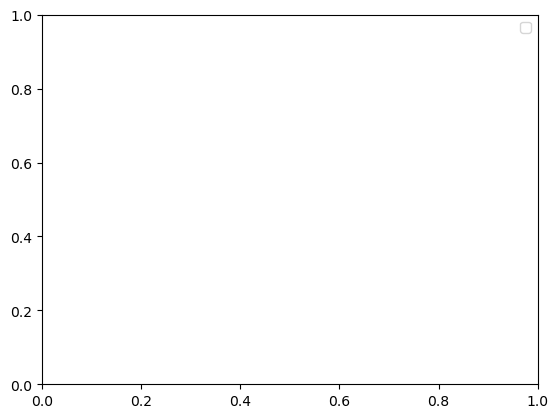

In [28]:
np.random.seed(2950)
mean_sightings = everything_df['Sightings'].mean()
std_sightings = everything_df['Sightings'].std()

normal_distribution = np.random.normal(mean_sightings, std_sightings, 10000)
plt.hist(normal_distribution, bins=100)
plt.xlabel('Sightings')
plt.ylabel('Frequency')
plt.title('Normal Distribution of Sightings')
plt.show()